In [64]:
# Loop through radii to examine correlation between vars
# at different scales of inquiry (10, 20, 30, 50, 80, 130 m radii)
# PB 2/16/23

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Added edits to tables on 4/19/23
# to include p values with spearman correlations
# for selenkay paper submission

# Awesome package for non-linear correlation analysis
# should be really useful for feature selection
# https://www.sciencedirect.com/science/article/pii/S2352711021000315#fig2
# https://github.com/ElsevierSoftwareX/SOFTX-D-20-00028
from ennemi import pairwise_mi, pairwise_corr

label = 'mango'

# options: "Red", "Black", '' (all soils)
soil = ''
# soil = "Black"
# soil = "Red"

# Datadir for location of in/out vars
datadir = '/n/home02/pbb/scripts/SelenkayDiversity/data/in'

# output dirs for figs
figd = f'/n/home02/pbb/scripts/SelenkayDiversity/figs/{label}'
tabled = f'/n/home02/pbb/scripts/halo-metadata-server/Selenkay/tables/{label}'


In [65]:
# makes matplotlib plots big
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams.update({'font.size': 16})

In [66]:
# radii to loop over
radii = [10, 20, 30, 50, 80, 130]

# Dict to save corr values 
shann_dict = {'SpearmanCorr':{10:[],
                             20:[],
                             30:[],
                             50:[],
                             80:[],
                             130:[]},
             'MICorr':{10:[],
                       20:[],
                       30:[],
                       50:[],
                       80:[],
                       130:[]},
             'pvalue':{10:[],
                       20:[],
                       30:[],
                       50:[],
                       80:[],
                       130:[]}}

abun_dict = {'SpearmanCorr':{10:[],
                             20:[],
                             30:[],
                             50:[],
                             80:[],
                             130:[]},
             'MICorr':{10:[],
                       20:[],
                       30:[],
                       50:[],
                       80:[],
                       130:[]}}
             
rich_dict = {'SpearmanCorr':{10:[],
                             20:[],
                             30:[],
                             50:[],
                             80:[],
                             130:[]},
             'MICorr':{10:[],
                       20:[],
                       30:[],
                       50:[],
                       80:[],
                       130:[]},
             'pvalue':{10:[],
                       20:[],
                       30:[],
                       50:[],
                       80:[],
                       130:[]}}

logrich_dict = {'SpearmanCorr':{10:[],
                             20:[],
                             30:[],
                             50:[],
                             80:[],
                             130:[]},
             'MICorr':{10:[],
                       20:[],
                       30:[],
                       50:[],
                       80:[],
                       130:[]}}
             
simp_dict = {'SpearmanCorr':{10:[],
                             20:[],
                             30:[],
                             50:[],
                             80:[],
                             130:[]},
             'MICorr':{10:[],
                       20:[],
                       30:[],
                       50:[],
                       80:[],
                       130:[]}}

In [67]:
# for each radius of inquiry
for radius in radii:

    # Load input data (cleaned in R)
    XY_scale = pd.read_csv(f'{datadir}/XY_scaled_{radius}mRadius.csv')
    
    # if a soil type is chosen above:
    if soil:
        # filter XY_scale for that soil type
        XY_scale = XY_scale.loc[XY_scale.Soil == f'{soil}']
        
    # Drop factor and character arrays from X df
    X = XY_scale.drop(['Unnamed: 0', 
                       'Richness', 'Abundance', 'Evenness', 'shannonH', 'Simpson',
                       'Spot', 'Soil_f', 'Treatment', 'Treatment_f', 'Transect_f', 'nlayers_plot_f'],
                      axis=1)
    
    # drops columns with NA in them
    # this was causing problems where the list of vars for each scale was not the same
    # took it out to fix it
    # X = X.dropna(axis=1)

    # Make y df
    y = XY_scale.filter(['Spot', 'Abundance', 'Richness', 'shannonH', 'Evenness', 'Simpson', 'Soil', 'Treatment'])
    y.head()
    
    # Add log spp richness 2/22/23
    y['logRichness'] = np.log(XY_scale.Richness)
    
    # Filter column and make dataframe
    cols = [c for c in X.columns if not (('iqr' in c) | ('max_' in c) | ('median' in c ) | ('Spot' in c))]
    # cols = [c for c in X.columns if not (('max_' in c) | ('Spot' in c))]
    
    XYcorr = pd.concat([X[cols],
                        y[['Abundance', 'Richness',
                           'shannonH', 'Simpson',
                           'Evenness', 'logRichness']]],
                       axis=1)
    
    if 'Soil' in XYcorr.columns:
        XYcorr = XYcorr.drop('Soil', axis=1)
    
    # run the MIcorr and SpearmanCorr methods
    for method in ['MICorr', 'SpearmanCorr']:
            
        # # # Compute correlation matrix
        
        if method == 'MICorr':
            
            corr = pairwise_corr(XYcorr,
                                 drop_nan=True)
            
        elif method == 'SpearmanCorr':
            
            # spearman grabs non-linear vars better
            # but note that it ignores vars with NaN 
            # https://stackoverflow.com/questions/57155427/how-does-corr-remove-na-and-null-values
            corr = XYcorr.corr(method='spearman')
            
            pvalues = XYcorr.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(len(XYcorr.columns))
            
            # Turn pvalue matrix back into a dataframe
            # clip out only the variables you're interested in
            pvalues = pd.DataFrame(pvalues[['Abundance', 'Richness',
                                            'shannonH', 'Evenness',
                                            'Simpson', 'logRichness']].iloc[0:-6])

        # Turn corr matrix back into a dataframe
        # clip out only the variables you're interested in
        corr = pd.DataFrame(corr[['Abundance', 'Richness',
                                  'shannonH', 'Evenness',
                                  'Simpson', 'logRichness']].iloc[0:-6])
        
        # Add to dictionaries to combine and save later
        shann_dict[method][radius].append(corr.shannonH)
        rich_dict[method][radius].append(corr.Richness)
        if method == 'SpearmanCorr':
            shann_dict['pvalue'][radius].append(pvalues.shannonH)
            rich_dict['pvalue'][radius].append(pvalues.Richness)
        abun_dict[method][radius].append(corr.Abundance)
        simp_dict[method][radius].append(corr.Simpson)
        logrich_dict[method][radius].append(corr.logRichness)
        
        # # SORTED METRICS 
        # Save each df as a table for later use
        
        # Note Shannon and richness also have pvalues attached to them
        if method == 'SpearmanCorr':
            shancorr = pd.DataFrame({'Correlation':shann_dict[method][radius][0],
                                     'pvalue':shann_dict['pvalue'][radius][0]}).sort_values('Correlation', ascending=False)
        elif method == 'MICorr':
            shancorr = pd.DataFrame(corr.shannonH.sort_values(ascending=False))
        shancorr.to_csv(f'{tabled}/{method}/{method}_shannonHxLidarMetrics_{radius}m{soil}_{label}.csv')
        
        if method == 'SpearmanCorr':
            richcorr = pd.DataFrame({'Correlation':rich_dict[method][radius][0],
                                     'pvalue':rich_dict['pvalue'][radius][0]}).sort_values('Correlation', ascending=False)
        elif method == 'MICorr':
            richcorr = pd.DataFrame(corr.Richness.sort_values(ascending=False))
            
        richcorr.to_csv(f'{tabled}/{method}/{method}_RichnessxLidarMetrics_{radius}m{soil}_{label}.csv')
        
    
        simpcorr = pd.DataFrame(corr.Simpson.sort_values(ascending=False))
        simpcorr.to_csv(f'{tabled}/{method}/{method}_SimpsonxLidarMetrics_{radius}m{soil}_{label}.csv')
        
        logrichcorr = pd.DataFrame(corr.logRichness.sort_values(ascending=False))
        logrichcorr.to_csv(f'{tabled}/{method}/{method}_logRichnessxLidarMetrics_{radius}m{soil}_{label}.csv')

        abuncorr = pd.DataFrame(corr.Abundance.sort_values(ascending=False))
        abuncorr.to_csv(f'{tabled}/{method}/{method}_AbundancexLidarMetrics_{radius}m{soil}_{label}.csv')
        

#          # unsorted metrics
#         # Save each df as a table for later use
#         shancorr = pd.DataFrame(corr.shannonH)
#         shancorr.to_csv(f'{tabled}/{method}/{method}_shannonHxLidarMetrics_{radius}m{soil}_{label}.csv')

#         simpcorr = pd.DataFrame(corr.Simpson)
#         simpcorr.to_csv(f'{tabled}/{method}/{method}_SimpsonxLidarMetrics_{radius}m{soil}_{label}.csv')

#         richcorr = pd.DataFrame(corr.Richness)
#         richcorr.to_csv(f'{tabled}/{method}/{method}_RichnessxLidarMetrics_{radius}m{soil}_{label}.csv')
        
#         logrichcorr = pd.DataFrame(corr.logRichness)
#         logrichcorr.to_csv(f'{tabled}/{method}/{method}_logRichnessxLidarMetrics_{radius}m{soil}_{label}.csv')

#         abuncorr = pd.DataFrame(corr.Abundance)
#         abuncorr.to_csv(f'{tabled}/{method}/{method}_AbundancexLidarMetrics_{radius}m{soil}_{label}.csv')

In [68]:
# Concat tables and save in one big file
shanncorr_combo_dict = {10:{'Metric':None,
                           'Correlation':None,
                           'pvalue':None},
                       20:{'Metric':None,
                           'Correlation':None,
                           'pvalue':None},
                       30:{'Metric':None,
                           'Correlation':None,
                           'pvalue':None},
                       50:{'Metric':None,
                           'Correlation':None,
                           'pvalue':None},
                       80:{'Metric':None,
                           'Correlation':None,
                           'pvalue':None},
                       130:{'Metric':None,
                            'Correlation':None,
                            'pvalue':None}}

for r in radii:

    shanncorr_combo_dict[r]['Metric'] = [v for v in shann_dict['SpearmanCorr'][r][0].index]
    shanncorr_combo_dict[r]['Correlation'] = [v for v in shann_dict['SpearmanCorr'][r][0].values]
    shanncorr_combo_dict[r]['pvalue'] = [v for v in shann_dict['pvalue'][r][0].values]
    
    print(len(shanncorr_combo_dict[r]['Metric'])) # print length to check that the length of variables is now all the same
    # this should be 114

shanncorr_combo_df = pd.DataFrame(shanncorr_combo_dict).T
shanncorr_combo_df.head()
shanncorr_combo_df.to_csv(f'{tabled}/SpearmanCorr_ShannonCombined_{radius}m{soil}_{label}.csv')

# Concat tables and save in one big file
rich_combo_dict = {10:{'Metric':None,
                           'Correlation':None,
                           'pvalue':None},
                       20:{'Metric':None,
                           'Correlation':None,
                           'pvalue':None},
                       30:{'Metric':None,
                           'Correlation':None,
                           'pvalue':None},
                       50:{'Metric':None,
                           'Correlation':None,
                           'pvalue':None},
                       80:{'Metric':None,
                           'Correlation':None,
                           'pvalue':None},
                       130:{'Metric':None,
                            'Correlation':None,
                            'pvalue':None}}

for r in radii:

    rich_combo_dict[r]['Metric'] = [v for v in rich_dict['SpearmanCorr'][r][0].index]
    rich_combo_dict[r]['Correlation'] = [v for v in rich_dict['SpearmanCorr'][r][0].values]
    rich_combo_dict[r]['pvalue'] = [v for v in rich_dict['pvalue'][r][0].values]
    
rich_combo_df = pd.DataFrame(rich_combo_dict).T
rich_combo_df.head()
rich_combo_df.to_csv(f'{tabled}/SpearmanCorr_RichnessCombined_{radius}m{soil}_{label}.csv')

114
114
114
114
114
114


In [103]:
# Perhaps, make boxplot of correlation differences here
# by soil type...

In [122]:
# Plots of variables, filtered by correlation 
# corrlim = 0.48
# Note: could add a correlation limit here where it grabs
# the 90th percentiles of max heights (top variables) for each method
# rather than a strict threshold

def CombinedPlotCorrbyScale(metric_dict, metric='', corrlim = 0.5, soil=''):
    
    fig1, ax1 = plt.subplots()
    fig2, ax2 = plt.subplots()
    

    for method, fig, ax in zip(['MICorr', 'SpearmanCorr'], [fig1, fig2], [ax1, ax2]):

        # https://seaborn.pydata.org/tutorial/color_palettes.html
        pal = sns.color_palette("husl", 12)
        # https://seaborn.pydata.org/generated/seaborn.set_palette.html
        sns.set_palette(pal)

        corr_combo = pd.DataFrame({10:metric_dict[method][10][0]})

        for r in [20, 30, 50, 80, 130]:

            df = pd.DataFrame({r:metric_dict['SpearmanCorr'][r][0]})
            
            # NOTE: To preserve the keys that don't overlap in each df
            # as in, cases where corr is NaN
            # need to do an outer join -
            # https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.join.html
            corr_combo = corr_combo.join(df, how = 'outer')

        corr_combo = corr_combo.T

        corr_combo['Radius'] = corr_combo.index

        colidx = corr_combo.apply(lambda x: max(abs(x)) >= corrlim, axis=0).values

        corr_combo_plot = corr_combo.loc[:, colidx]

        # corr_combo_plot

        for k in corr_combo_plot.keys():

            if k != 'Radius':

                sns.lineplot(data=corr_combo_plot, 
                             x='Radius',
                             y=f'{k}',
                             label=k,
                             ax=ax)

                ax.legend(loc='center left',
                          bbox_to_anchor=(1, 0.5),
                          ncol=1,
                          fancybox=True)

        ax.set_ylabel('Correlation')

        ax.set_title(f'{method} > {corrlim}')
        
        plt.suptitle(f'{metric} {soil}')
    # fig.tight_layout()
        
    return corr_combo, fig1, ax1, fig2, ax2

/tmp/ipykernel_185484/2056749743.py:24: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig1.tight_layout()


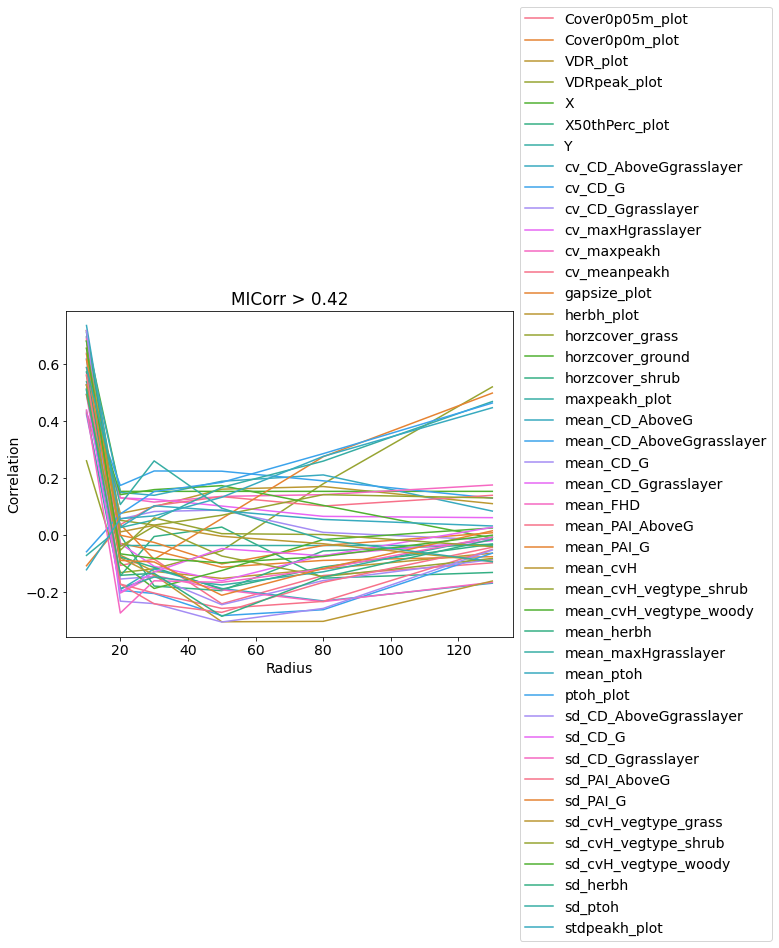

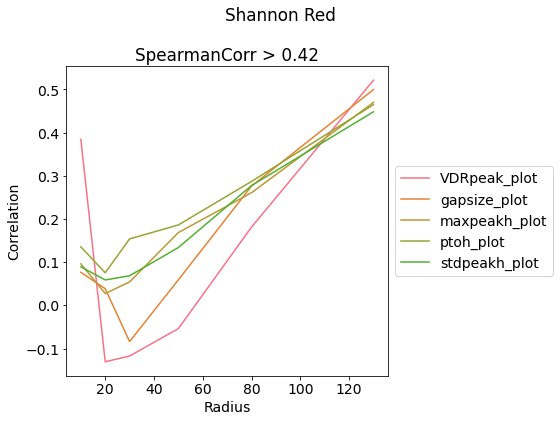

In [128]:
# makes matplotlib plots big
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams.update({'font.size': 14})

if soil == 'Black':
    cr = 0.8
elif soil == 'Red':
    cr = 0.42
else:
    cr = 0.46

# set upper limit on corr to only plot top 5 variables
# NOTE doesn't work, cause only looks at 1 scale of inquiry
# for spearmancorr
# cr = shancorr.sort_values(by='shannonH', ascending=False).iloc[5].values[0]

m = 'Shannon'

shancorr_combo, fig1, ax1, fig2, ax2 = CombinedPlotCorrbyScale(metric_dict=shann_dict,
                                                        metric=m,
                                                        corrlim = cr,
                                                        soil=soil)

fig1.tight_layout()
fig2.tight_layout()

fig1.savefig(f'./figs/mango/LinePlot_MICorr_{m}TopVariablesbyScale{soil}.png', dpi=300)

fig2.savefig(f'./figs/mango/LinePlot_SpearmanCorr_{m}TopVariablesbyScale{soil}.png', dpi=300)

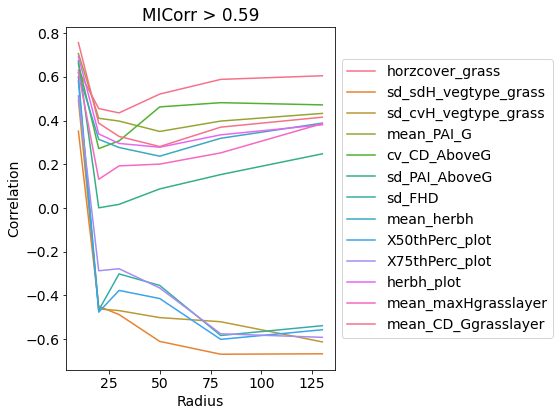

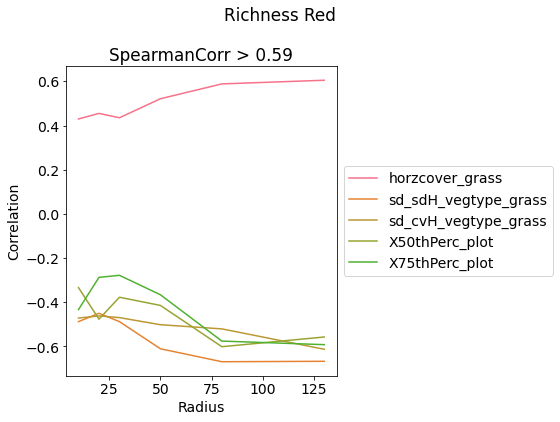

In [113]:
if soil == 'Black':
    cr = 0.64
elif soil == 'Red':
    cr = 0.59
else:
    cr = 0.38

m = 'Richness'

shancorr_combo, fig1, ax1, fig2, ax2 = CombinedPlotCorrbyScale(metric_dict=rich_dict,
                                                        metric=m,
                                                        corrlim = cr,
                                                        soil=soil)

fig1.tight_layout()
fig2.tight_layout()

fig1.savefig(f'./figs/mango/LinePlot_MICorr_{m}TopVariablesbyScale{soil}.png', dpi=300)

fig2.savefig(f'./figs/mango/LinePlot_SpearmanCorr_{m}TopVariablesbyScale{soil}.png', dpi=300)

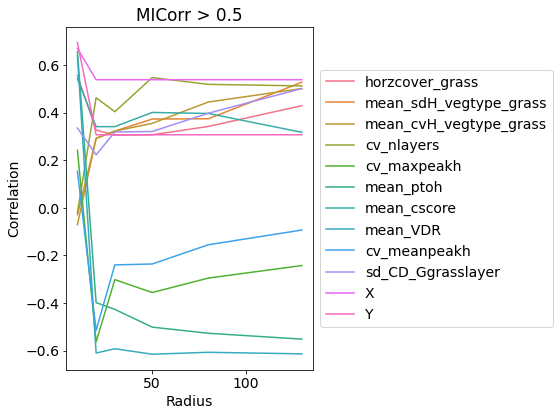

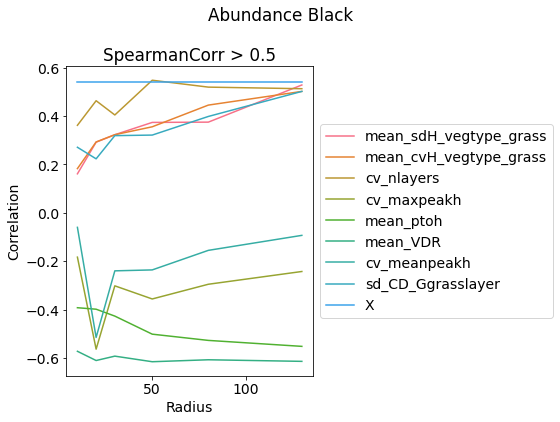

In [94]:


if soil == 'Black':
    cr = 0.5
elif soil == 'Red':
    cr = 0.56
else:
    cr = 0.40

m = 'Abundance'

shancorr_combo, fig1, ax1, fig2, ax2 = CombinedPlotCorrbyScale(metric_dict=abun_dict,
                                                        metric=m,
                                                        corrlim = cr,
                                                        soil=soil)

fig1.tight_layout()
fig2.tight_layout()

fig1.savefig(f'./figs/mango/LinePlot_MICorr_{m}TopVariablesbyScale{soil}.png', dpi=300)

fig2.savefig(f'./figs/mango/LinePlot_SpearmanCorr_{m}TopVariablesbyScale{soil}.png', dpi=300)

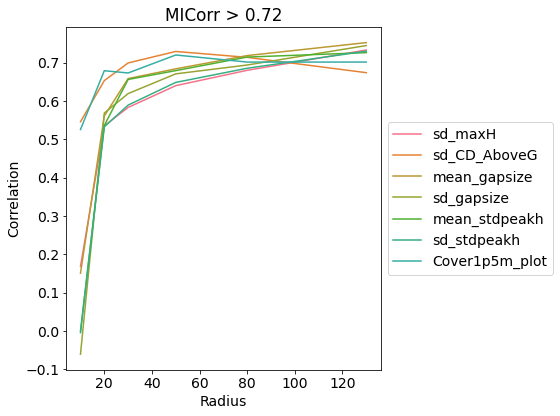

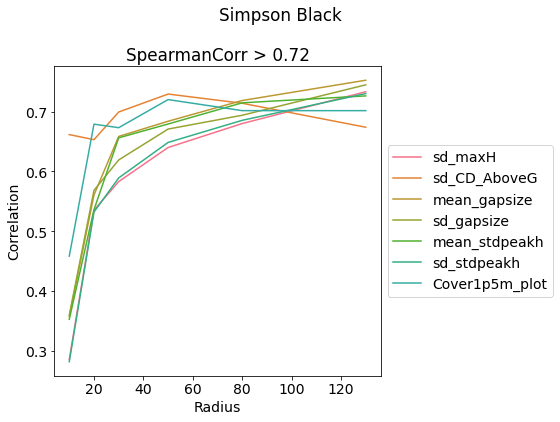

In [95]:


if soil == 'Black':
    cr = 0.72
elif soil == 'Red':
    cr = 0.42
else:
    cr = 0.5

m = 'Simpson'

shancorr_combo, fig1, ax1, fig2, ax2 = CombinedPlotCorrbyScale(metric_dict=simp_dict,
                                                        metric=m,
                                                        corrlim = cr,
                                                        soil=soil)

fig1.tight_layout()
fig2.tight_layout()

fig1.savefig(f'./figs/mango/LinePlot_MICorr_{m}TopVariablesbyScale{soil}.png', dpi=300)

fig2.savefig(f'./figs/mango/LinePlot_SpearmanCorr_{m}TopVariablesbyScale{soil}.png', dpi=300)

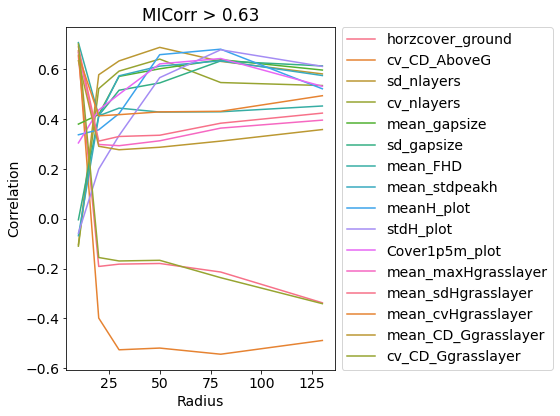

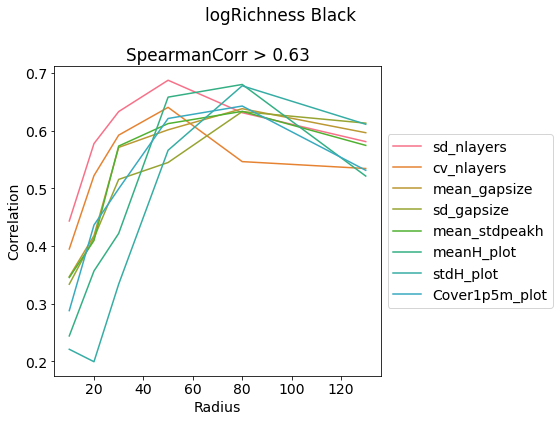

In [96]:


if soil == 'Black':
    cr = 0.63
elif soil == 'Red':
    cr = 0.55
else:
    cr = 0.37

m = 'logRichness'

shancorr_combo, fig1, ax1, fig2, ax2 = CombinedPlotCorrbyScale(metric_dict=logrich_dict,
                                                        metric=m,
                                                        corrlim = cr,
                                                        soil=soil)

fig1.tight_layout()
fig2.tight_layout()

fig1.savefig(f'./figs/mango/LinePlot_MICorr_{m}TopVariablesbyScale{soil}.png', dpi=300)

fig2.savefig(f'./figs/mango/LinePlot_SpearmanCorr_{m}TopVariablesbyScale{soil}.png', dpi=300)

### Scraps

In [11]:
# shancorr_combo = pd.DataFrame({10:shann_dict['SpearmanCorr'][10][0]})

# # df_list = []

# for r in [20, 30, 50, 80, 130]:
    
#     df = pd.DataFrame({r:shann_dict['SpearmanCorr'][r][0]})
    
# #     shancorr_combo = pd.merge(shancorr_combo, df, 
# #                               left_index=True, right_index=True)

    
#     shancorr_combo = shancorr_combo.join(df)
    

# shancorr_combo = shancorr_combo.T

# shancorr_combo['Radius'] = shancorr_combo.index
#     # df = pd.DataFrame({r:shann_dict['SpearmanCorr'][r][0].values})
    
#     df_list.append(df)

# shanncorr_combo = pd.concat(df_list, axis=1)

# df = pd.DataFrame(shann_dict['SpearmanCorr'][10][0])
# shanncorr_combo.assign(Metric=df.index, inplace=True)
    

In [12]:
# sns.lineplot(data=shancorr_combo_plot, 
#              x='Radius',
#              y='X25thPerc_plot',
#              label=k)